In [7]:
library("dplyr")
library("Seurat")
library("patchwork")
library("Matrix")
library("biomaRt")  
library("ggplot2")
library("celda")  
library("DoubletFinder")
library("harmony")  
library("presto")  
library("biomaRt")
library("glmGamPoi")
library("RColorBrewer")
set.seed(1234)

# Import data


In [ ]:
input_dirs <- c("/cellranger/count/MR24_R10_trp1_S28/outs/",
               "/cellranger/count/MR24_R12_trp2_S13/outs/",
               "/cellranger/count/MR24_R7_trp3_S16/outs/",
               "/cellranger/count/MR24_R2_trp4_S8/outs/")

Run_DecontX = function(input_dir, organism_of_interest = "GRCh38_w_Barcode_", min.cells = 3, min.features = 200, use.raw = TRUE) {
    sample_name <- basename(dirname(input_dir))
    #import filtered and raw counts and filter for organism of interest
    counts <- Read10X(paste0(input_dir, "/filtered_feature_bc_matrix/"), gene.column = 1)
    counts <- counts[grep(x = rownames(counts), pattern = organism_of_interest), ]
    rownames(counts) <- gsub(x = rownames(counts), pattern = organism_of_interest, replacement = "")
    if (use.raw == TRUE) {
      counts.raw <- Read10X(paste0(input_dir, "/raw_feature_bc_matrix/"))
      counts.raw <- counts.raw[grep(x = rownames(counts.raw), pattern = organism_of_interest), ]
      rownames(counts.raw) <- gsub(x = rownames(counts.raw), pattern = organism_of_interest, replacement = "")
      #create SingleCellExperiment objects
      sce <- SingleCellExperiment(list(counts = counts))
      sce.raw <- SingleCellExperiment(list(counts = counts.raw))
      #Run DecontX
      sce <- decontX(sce, background = sce.raw)
    } else {
      #create SingleCellExperiment objects
      sce <- SingleCellExperiment(list(counts = counts))
      #Run DecontX
      sce <- decontX(sce)   
    }
    seuratObject <- CreateSeuratObject(round(decontXcounts(sce)), project = sample_name, min.cells = min.cells, min.features = min.features)
    return(seuratObject)
}

MR24_R10_trp1 <- Run_DecontX(input_dir = input_dirs[1], use.raw = TRUE)
MR24_R12_trp2 <- Run_DecontX(input_dir = input_dirs[2], use.raw = TRUE)
MR24_R7_trp3 <- Run_DecontX(input_dir = input_dirs[3], use.raw = TRUE)
MR24_R2_trp4 <- Run_DecontX(input_dir = input_dirs[4], use.raw = TRUE)

In [ ]:
input_dirs <- c("/cellranger/count/MR24_R12_trp3_S23/outs/",
               "/cellranger/count/MR24_R2_trp3_S22/outs/")

Run_DecontX = function(input_dir, organism_of_interest = "GRCh38_", min.cells = 3, min.features = 200, use.raw = TRUE) {
    sample_name <- basename(dirname(input_dir))
    #import filtered and raw counts and filter for organism of interest
    counts <- Read10X(paste0(input_dir, "/filtered_feature_bc_matrix/"), gene.column = 1)
    counts <- counts[grep(x = rownames(counts), pattern = organism_of_interest), ]
    rownames(counts) <- gsub(x = rownames(counts), pattern = organism_of_interest, replacement = "")
    if (use.raw == TRUE) {
      counts.raw <- Read10X(paste0(input_dir, "/raw_feature_bc_matrix/"))
      counts.raw <- counts.raw[grep(x = rownames(counts.raw), pattern = organism_of_interest), ]
      rownames(counts.raw) <- gsub(x = rownames(counts.raw), pattern = organism_of_interest, replacement = "")
      #create SingleCellExperiment objects
      sce <- SingleCellExperiment(list(counts = counts))
      sce.raw <- SingleCellExperiment(list(counts = counts.raw))
      #Run DecontX
      sce <- decontX(sce, background = sce.raw)
    } else {
      #create SingleCellExperiment objects
      sce <- SingleCellExperiment(list(counts = counts))
      #Run DecontX
      sce <- decontX(sce)   
    }
    umap <- reducedDim(sce, "decontX_UMAP")
    seuratObject <- CreateSeuratObject(round(decontXcounts(sce)), project = sample_name, min.cells = min.cells, min.features = min.features)
    return(seuratObject)
}

MR24_R12_trp3_S23 <- Run_DecontX(input_dir = input_dirs[1], use.raw = TRUE)
MR24_R2_trp3_S22 <- Run_DecontX(input_dir = input_dirs[2], use.raw = TRUE)

In [ ]:
grafts_conf <- merge(MR24_R10_trp1, y = c(MR24_R12_trp2, MR24_R7_trp3, MR24_R2_trp4, MR24_R12_trp3_S23, MR24_R2_trp3_S22),
                     add.cell.ids = c("MR24_R10_trp1", "MR24_R12_trp2", "MR24_R7_trp3", "MR24_R2_trp4", "MR24_R12_trp3_S23", "MR24_R2_trp3_S22"), project = "grafts")
grafts_conf <- JoinLayers(grafts_conf, assay = 'RNA')

### Mitochondrial percentage

In [ ]:
# Connetti a Ensembl
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mito_genes <- getBM(attributes = c("ensembl_gene_id", "external_gene_name", "chromosome_name"),
                    filters = "chromosome_name", values = "MT", mart = ensembl)
mito_genes <- mito_genes$ensembl_gene_id[mito_genes$ensembl_gene_id %in% rownames(grafts_conf)]
grafts_conf$percent.mt <- PercentageFeatureSet(grafts_conf, features = mito_genes, assay = 'RNA')

## QC filters

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


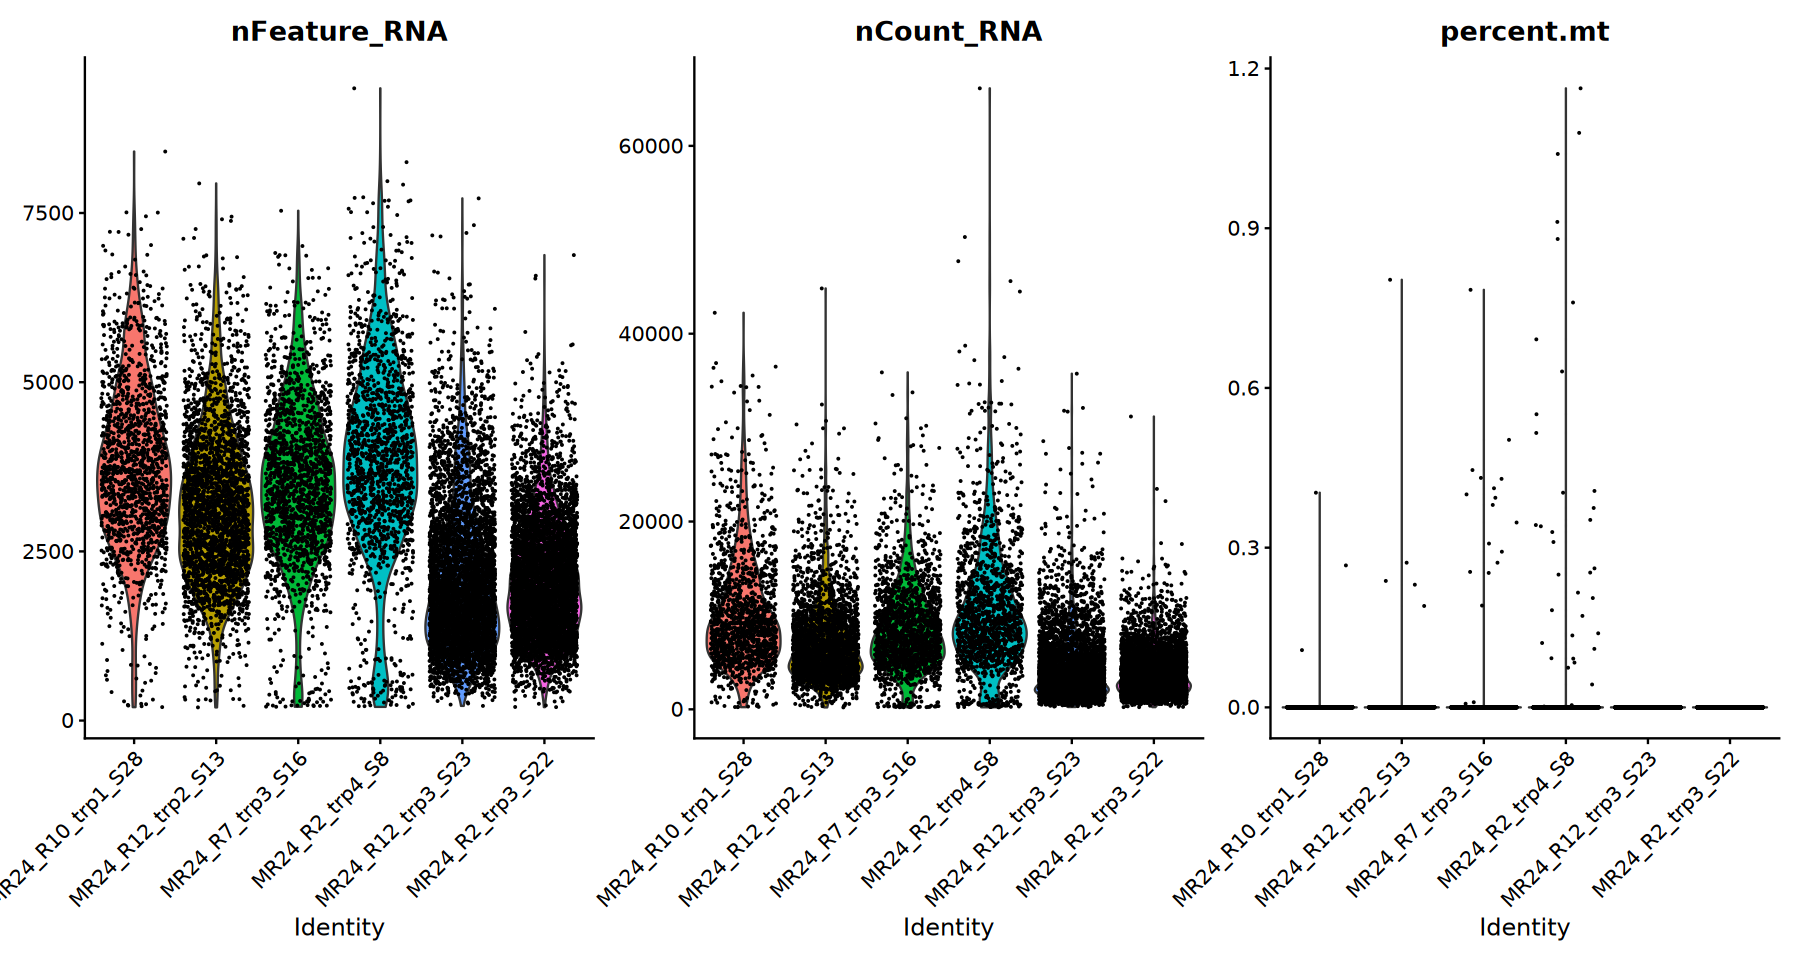

In [233]:
VlnPlot(grafts_conf, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


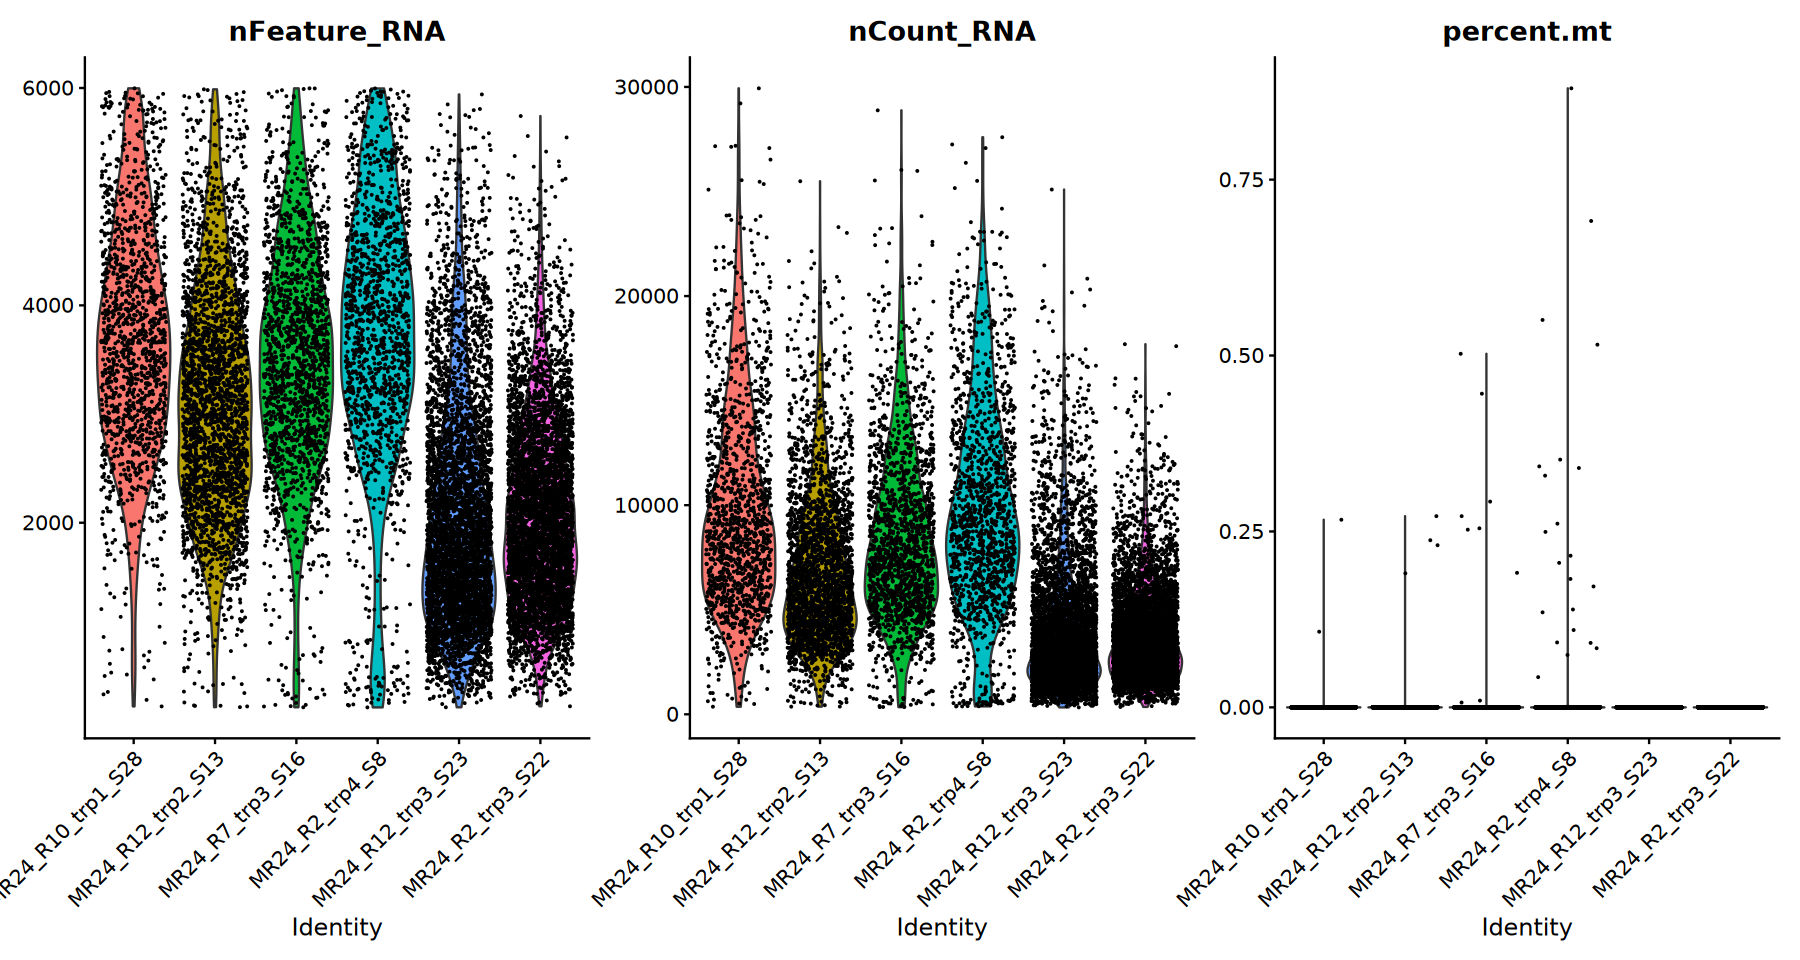

In [236]:
grafts_conf <- subset(grafts_conf, subset = nFeature_RNA > 300 & nFeature_RNA < 6000 & nCount_RNA > 300 & nCount_RNA < 30000 & percent.mt < 1)

VlnPlot(grafts_conf, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

## SCTransform normalization & UMAP

In [ ]:
grafts_conf <- SCTransform(grafts_conf, vst.flavor = "v2", variable.features.n = 3000, ncells = 5000, verbose = FALSE)

In [ ]:
#Cell cycle scoring
human_sub_genes <- readRDS('/GTF_HumanGenes_IDandName_subsetted.rds')
human_s.genes <- subset(human_sub_genes, subset = name %in% cc.genes$s.genes)
s.genes <- human_s.genes$gene_id

human_g2m.genes <- subset(human_sub_genes, subset = name %in% cc.genes$g2m.genes)
g2m.genes <- human_g2m.genes$gene_id
grafts_conf <- CellCycleScoring(grafts_conf, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
grafts_conf$CC.Difference <- grafts_conf$S.Score - grafts_conf$G2M.Score

In [ ]:
grafts_conf <- RunPCA(grafts_conf, features = VariableFeatures(object = neuronal), npcs = 50, reduction.name = "pcaCC")
ElbowPlot(grafts_conf, reduction = "pca", ndims = 50)

num_dims <- 50
grafts_conf <- RunUMAP(grafts_conf, dims = 1:num_dims, reduction = "pca", reduction.name = "umap", reduction.key = "umap", verbose = FALSE)

## Batch integration

In [ ]:
grafts_conf_batch <- RunHarmony(grafts_conf, 'orig.ident', orig.reduction = "pca", reduction.name = "harmonyPca", assay = "SCT", verbose = FALSE)

In [ ]:
num_dims <- 50

#Clustering loop
grafts_conf_batch <- FindNeighbors(grafts_conf_batch, reduction = "harmony", dims = 1:num_dims)
for (res_val in seq(0.05, 0.85, 0.2)) {
  grafts_conf_batch <- FindClusters(grafts_conf_batch, resolution = res_val, method = 4)
  grafts_conf_batch <- RunUMAP(grafts_conf_batch, dims = 1:num_dims, reduction = "harmony", reduction.name = "harmony_umap")
}

## Annotation

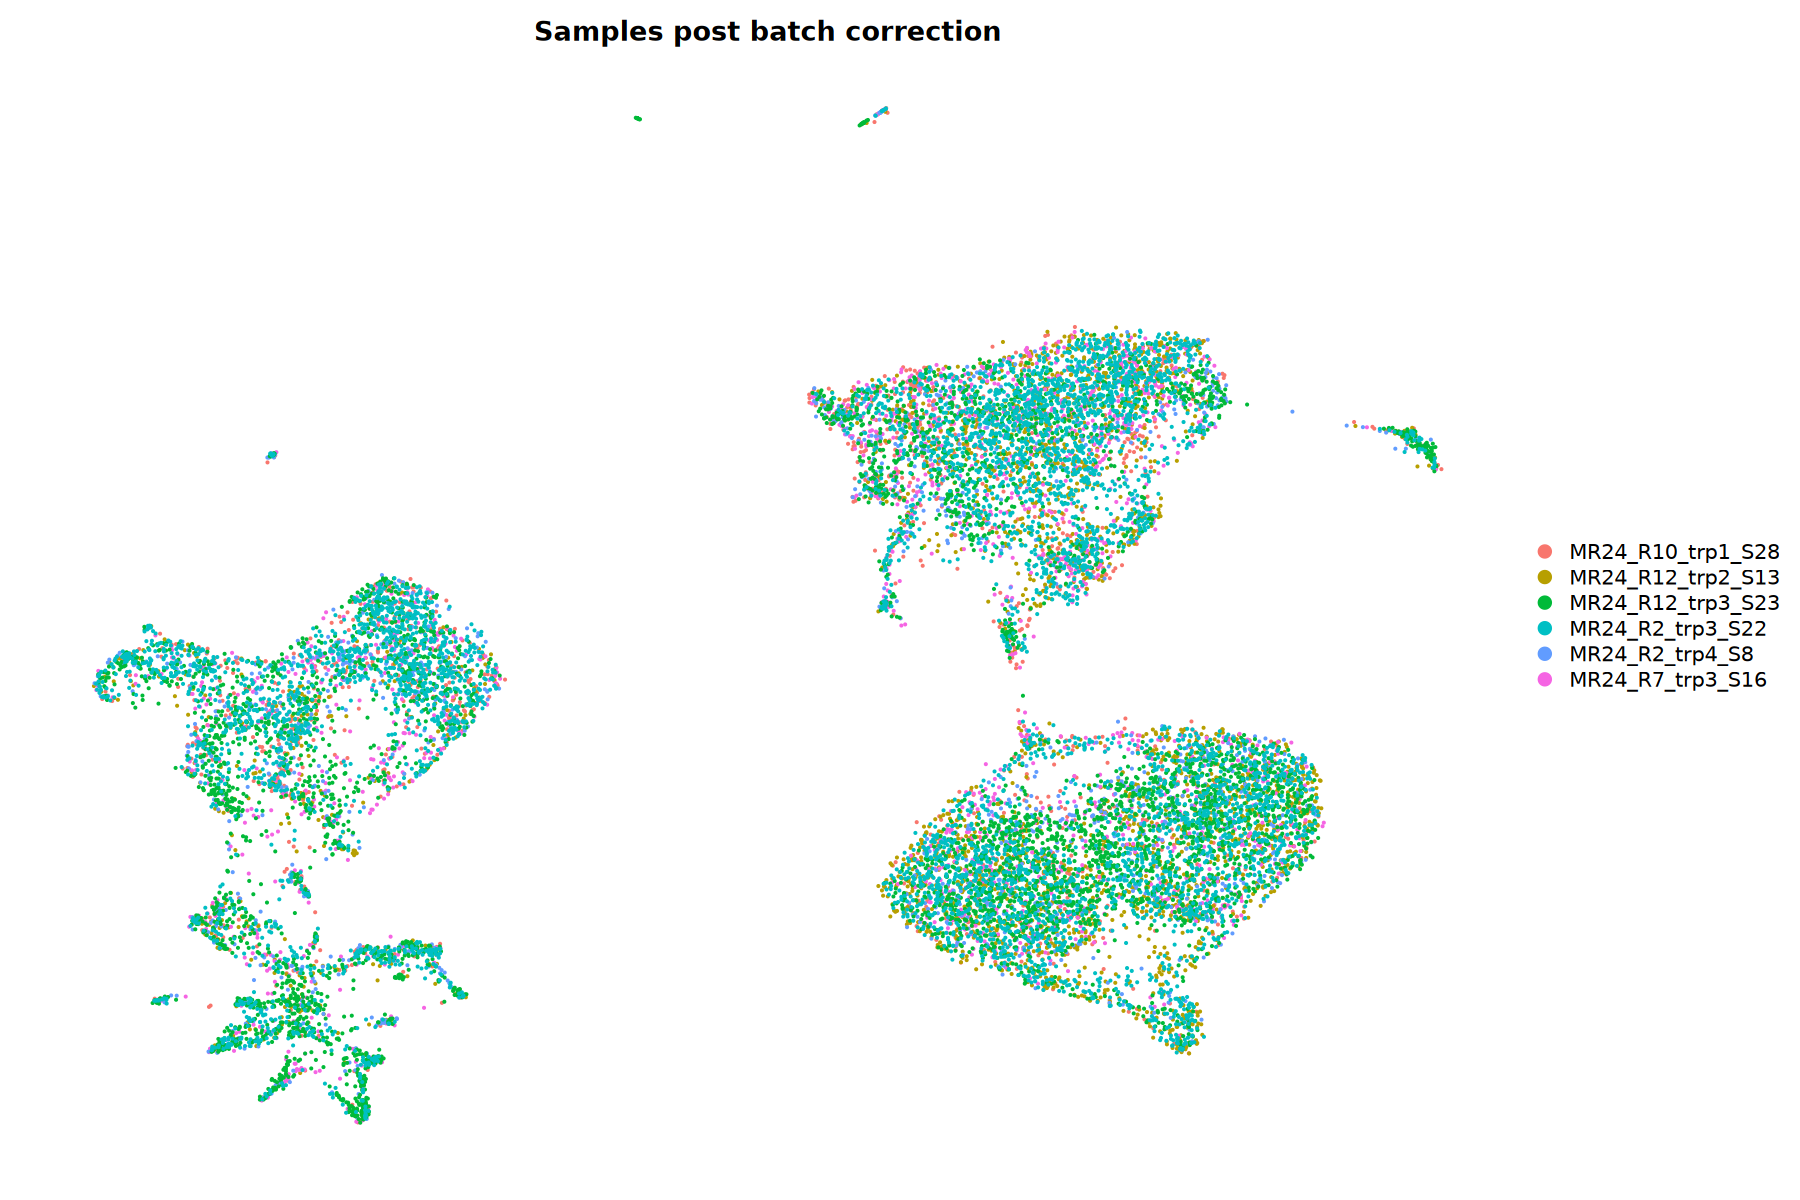

In [340]:
options(repr.plot.width=15, repr.plot.height=10)   

DimPlot(grafts_conf_batch, reduction = "harmony_umap", group.by = "orig.ident", pt.size = 0.1) + ggtitle("Samples post batch correction") + NoAxes() 

In [ ]:
grafts_conf_batch$annotation_markers <- 'none'
grafts_conf_batch$annotation_markers <- ifelse(grafts_conf_batch$SCT_snn_res.0.05 == 0 | grafts_conf_batch$SCT_snn_res.0.05 == 1 | 
                                                   grafts_conf_batch$SCT_snn_res.0.05 == 4 | grafts_conf_batch$SCT_snn_res.0.05 == 5 & grafts_conf_batch$annotation_markers == 'none', 'Astrocytes',
                                               ifelse(grafts_conf_batch$SCT_snn_res.0.45 == 3 & grafts_conf_batch$annotation_markers == 'none', 'MGE-LAMP5 interneurons', 
                                               ifelse(grafts_conf_batch$SCT_snn_res.0.65 == 9 & grafts_conf_batch$annotation_markers == 'none', 'CGE interneurons',
                                               ifelse(grafts_conf_batch$SCT_snn_res.0.45 == 10 | grafts_conf_batch$SCT_snn_res.0.45 == 5 | grafts_conf_batch$SCT_snn_res.0.45 == 16
                                                          & grafts_conf_batch$annotation_markers == 'none', 'MSN-like',
                                               ifelse(grafts_conf_batch$SCT_snn_res.0.65 == 4 & grafts_conf_batch$annotation_markers == 'none', 'MGE-like interneurons',
                                               ifelse(grafts_conf_batch$SCT_snn_res.0.45 == 11 | grafts_conf_batch$SCT_snn_res.0.45 == 13 
                                                          & grafts_conf_batch$annotation_markers == 'none', 'Emerging MSNs',
                                                      grafts_conf_batch$annotation_markers))))))

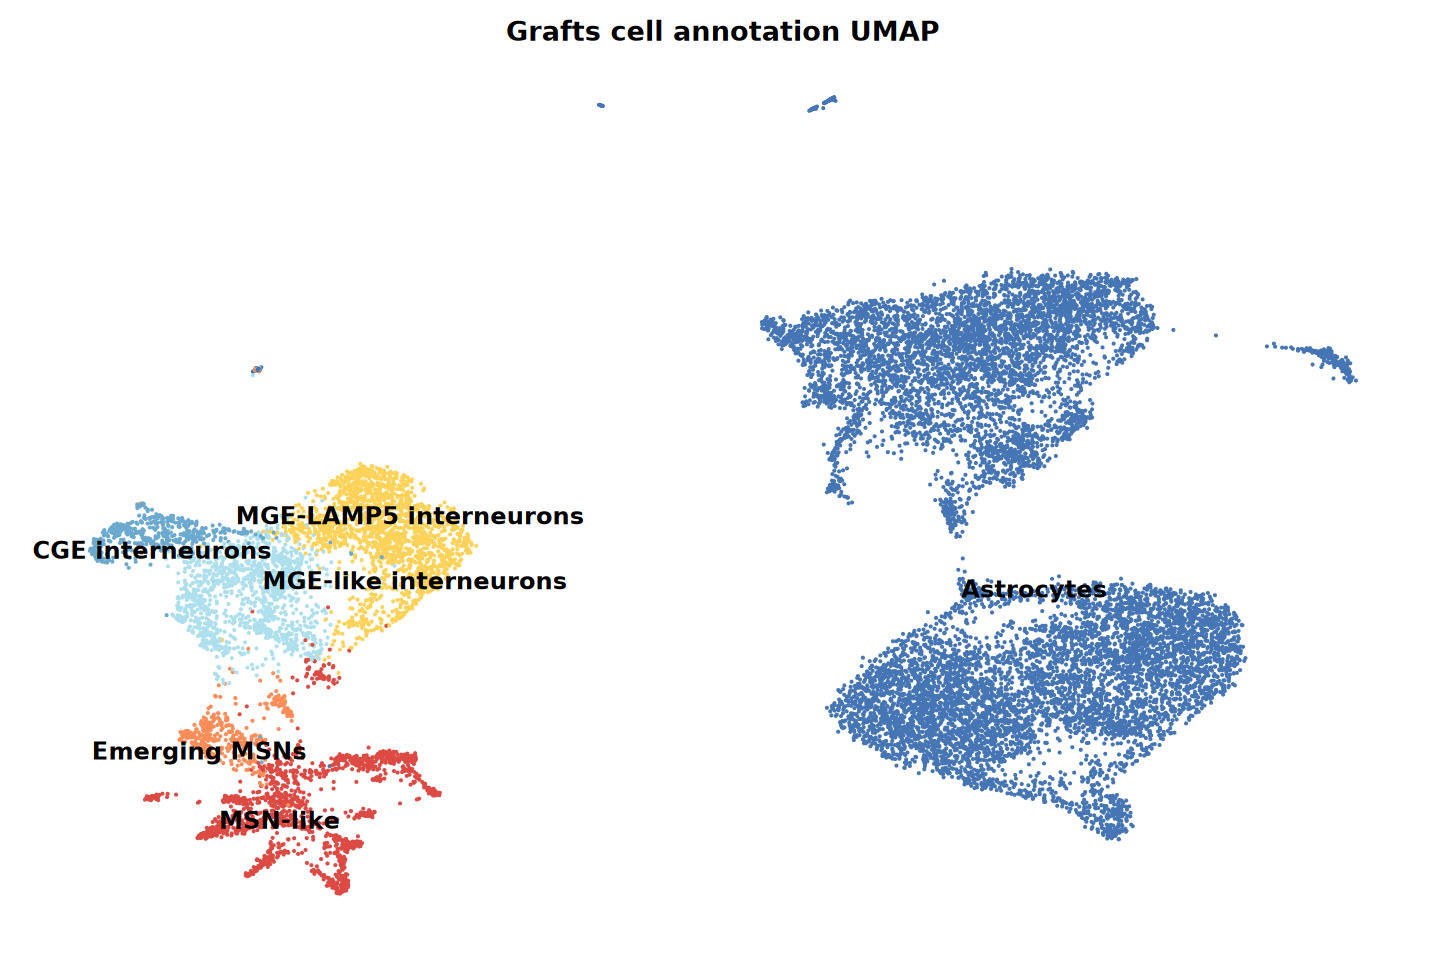

In [206]:
options(repr.plot.width=12, repr.plot.height=8) 

colors <- c('#4575B4', '#6BA9CF', '#ADDFED', '#FDD259', '#FC8D59', '#DD4A43', 'orange2')

p <- DimPlot(grafts_conf_batch, reduction = "harmony_umap", group.by = "annotation_markers", pt.size = 0.1, cols = colors) + 
    NoLegend() + NoAxes() +
    ggtitle('Grafts cell annotation UMAP') 
    LabelClusters(p, id = "annotation_markers", fontface = "bold", size = 5)

## Markers plot

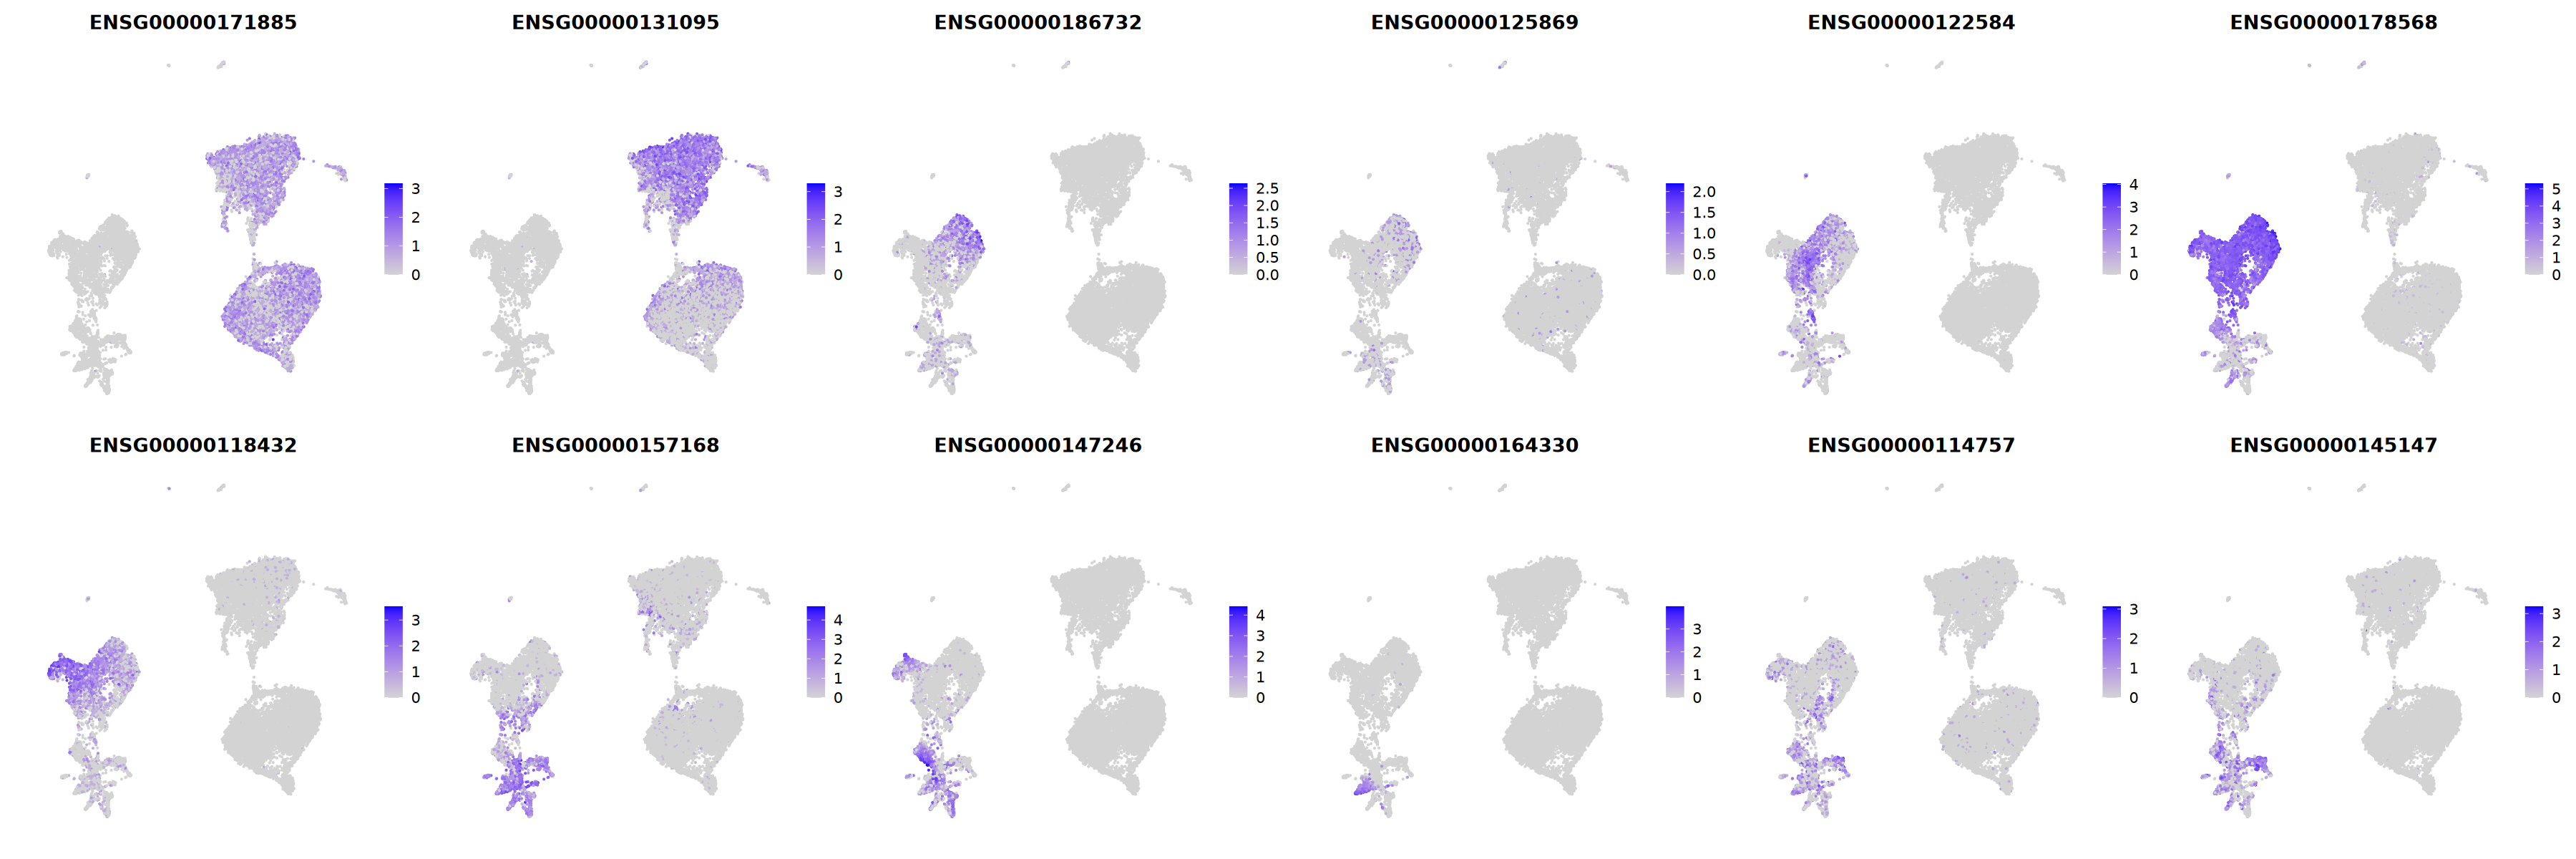

In [195]:
options(repr.plot.width=30, repr.plot.height=10) 

FeaturePlot(grafts_conf_batch, reduction = 'harmony_umap', pt.size = 0.1, ncol = 6, 
                                            features = c('ENSG00000171885', #AQP4 
                                                         'ENSG00000131095', #GFAP
                                                         'ENSG00000186732', #MPPED1 
                                                         'ENSG00000125869', #LAMP5
                                                         'ENSG00000122584', #NXPH1 
                                                         'ENSG00000178568', #ERBB4
                                                         'ENSG00000118432', #CNR1
                                                         'ENSG00000157168', #NRG1                                                          
                                                         'ENSG00000147246', #HTR2C
                                                         'ENSG00000164330', #EBF1 
                                                         'ENSG00000114757', #PEX5L
                                                         'ENSG00000145147' #SLIT2
                                                           )) & NoAxes()

In [176]:
marker_genes <- list(
    'Astrocytes' =             c('ENSG00000171885', #AQP4 
                                 'ENSG00000131095', #GFA
                                 'ENSG00000079215'), #SLC1A3
    
    'CGE interneurons' =       c('ENSG00000185736', #ADARB2
                                 'ENSG00000172137', #CALB2
                                 'ENSG00000118432', #CNR1
                                 'ENSG00000130751', #NPAS1
                                 'ENSG00000062096',  #ARSF
                                 'ENSG00000122420'), #PTGFR
    
    'MGE-like interneurons' =  c('ENSG00000102024', #PLS3 
                                'ENSG00000122584', #NXPH1
                                'ENSG00000198597', #ZNF536
                                'ENSG00000178568'), #ERBB4 
    
    'MGE-LAMP5 interneurons' = c('ENSG00000125869', #LAMP5 
                                 'ENSG00000186732', #MPPED1
                                 'ENSG00000185053', #SGCZ
                                 'ENSG00000149972',  #CNTN5
                                 'ENSG00000102678'), #FGF9'
    
    'Emerging MSNs' =          c('ENSG00000110693', #SOX6 
                                 'ENSG00000147246', #HTR2C
                                 'ENSG00000113319'),#RASGRF2
    
    'Pre-D1-MSN-like' =        c('ENSG00000164330', #EBF1  
                                 'ENSG00000016082', #ISL1
                                 'ENSG00000148680', #HTR7
                                 'ENSG00000167081'),  #PBX3
    
    'Pre-D2-MSN-like' =        c('ENSG00000145147', #SLIT2 
                                 'ENSG00000114757', #PEX5L     
                                 'ENSG00000217236', #SP9
                                 'ENSG00000138083' #SIX3
                         ))

In [177]:
ensembl_to_symbol <- c(
    #Astrocytes
    'ENSG00000171885' = 'AQP4', 'ENSG00000131095' = 'GFAP', 'ENSG00000079215' = 'SLC1A3', 
    #CGE interneurons
    'ENSG00000185736' = 'ADARB2', 'ENSG00000172137' = 'CALB2', 'ENSG00000118432' = 'CNR1', 'ENSG00000130751' = 'NPAS1', 'ENSG00000062096' = 'ARSF', 'ENSG00000122420' = 'PTGFR',
    #MGE-like interneurons
    'ENSG00000102024' = 'PLS3', 'ENSG00000122584' = 'NXPH1', 'ENSG00000198597' = 'ZNF536', 'ENSG00000178568' = 'ERBB4',
    #MGE-LAMP5 interneurons
    'ENSG00000125869' = 'LAMP5', 'ENSG00000186732' = 'MPPED1', 'ENSG00000185053' = 'SGCZ', 'ENSG00000149972' = 'CNTN5', 'ENSG00000102678' = 'FGF9',
    #Emerging MSNs
    'ENSG00000110693' = 'SOX6', 'ENSG00000147246' = 'HTR2C', 'ENSG00000113319' = 'RASGRF2',    
    #Pre-D1-MSN-like
    'ENSG00000164330' = 'EBF1', 'ENSG00000016082' = 'ISL1', 'ENSG00000148680' = 'HTR7', 'ENSG00000167081' = 'PBX3',
    #Pre-D2-MSN-like
    'ENSG00000145147' = 'SLIT2', 'ENSG00000114757' = 'PEX5L', 'ENSG00000217236' = 'SP9', 'ENSG00000138083' = 'SIX3')

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


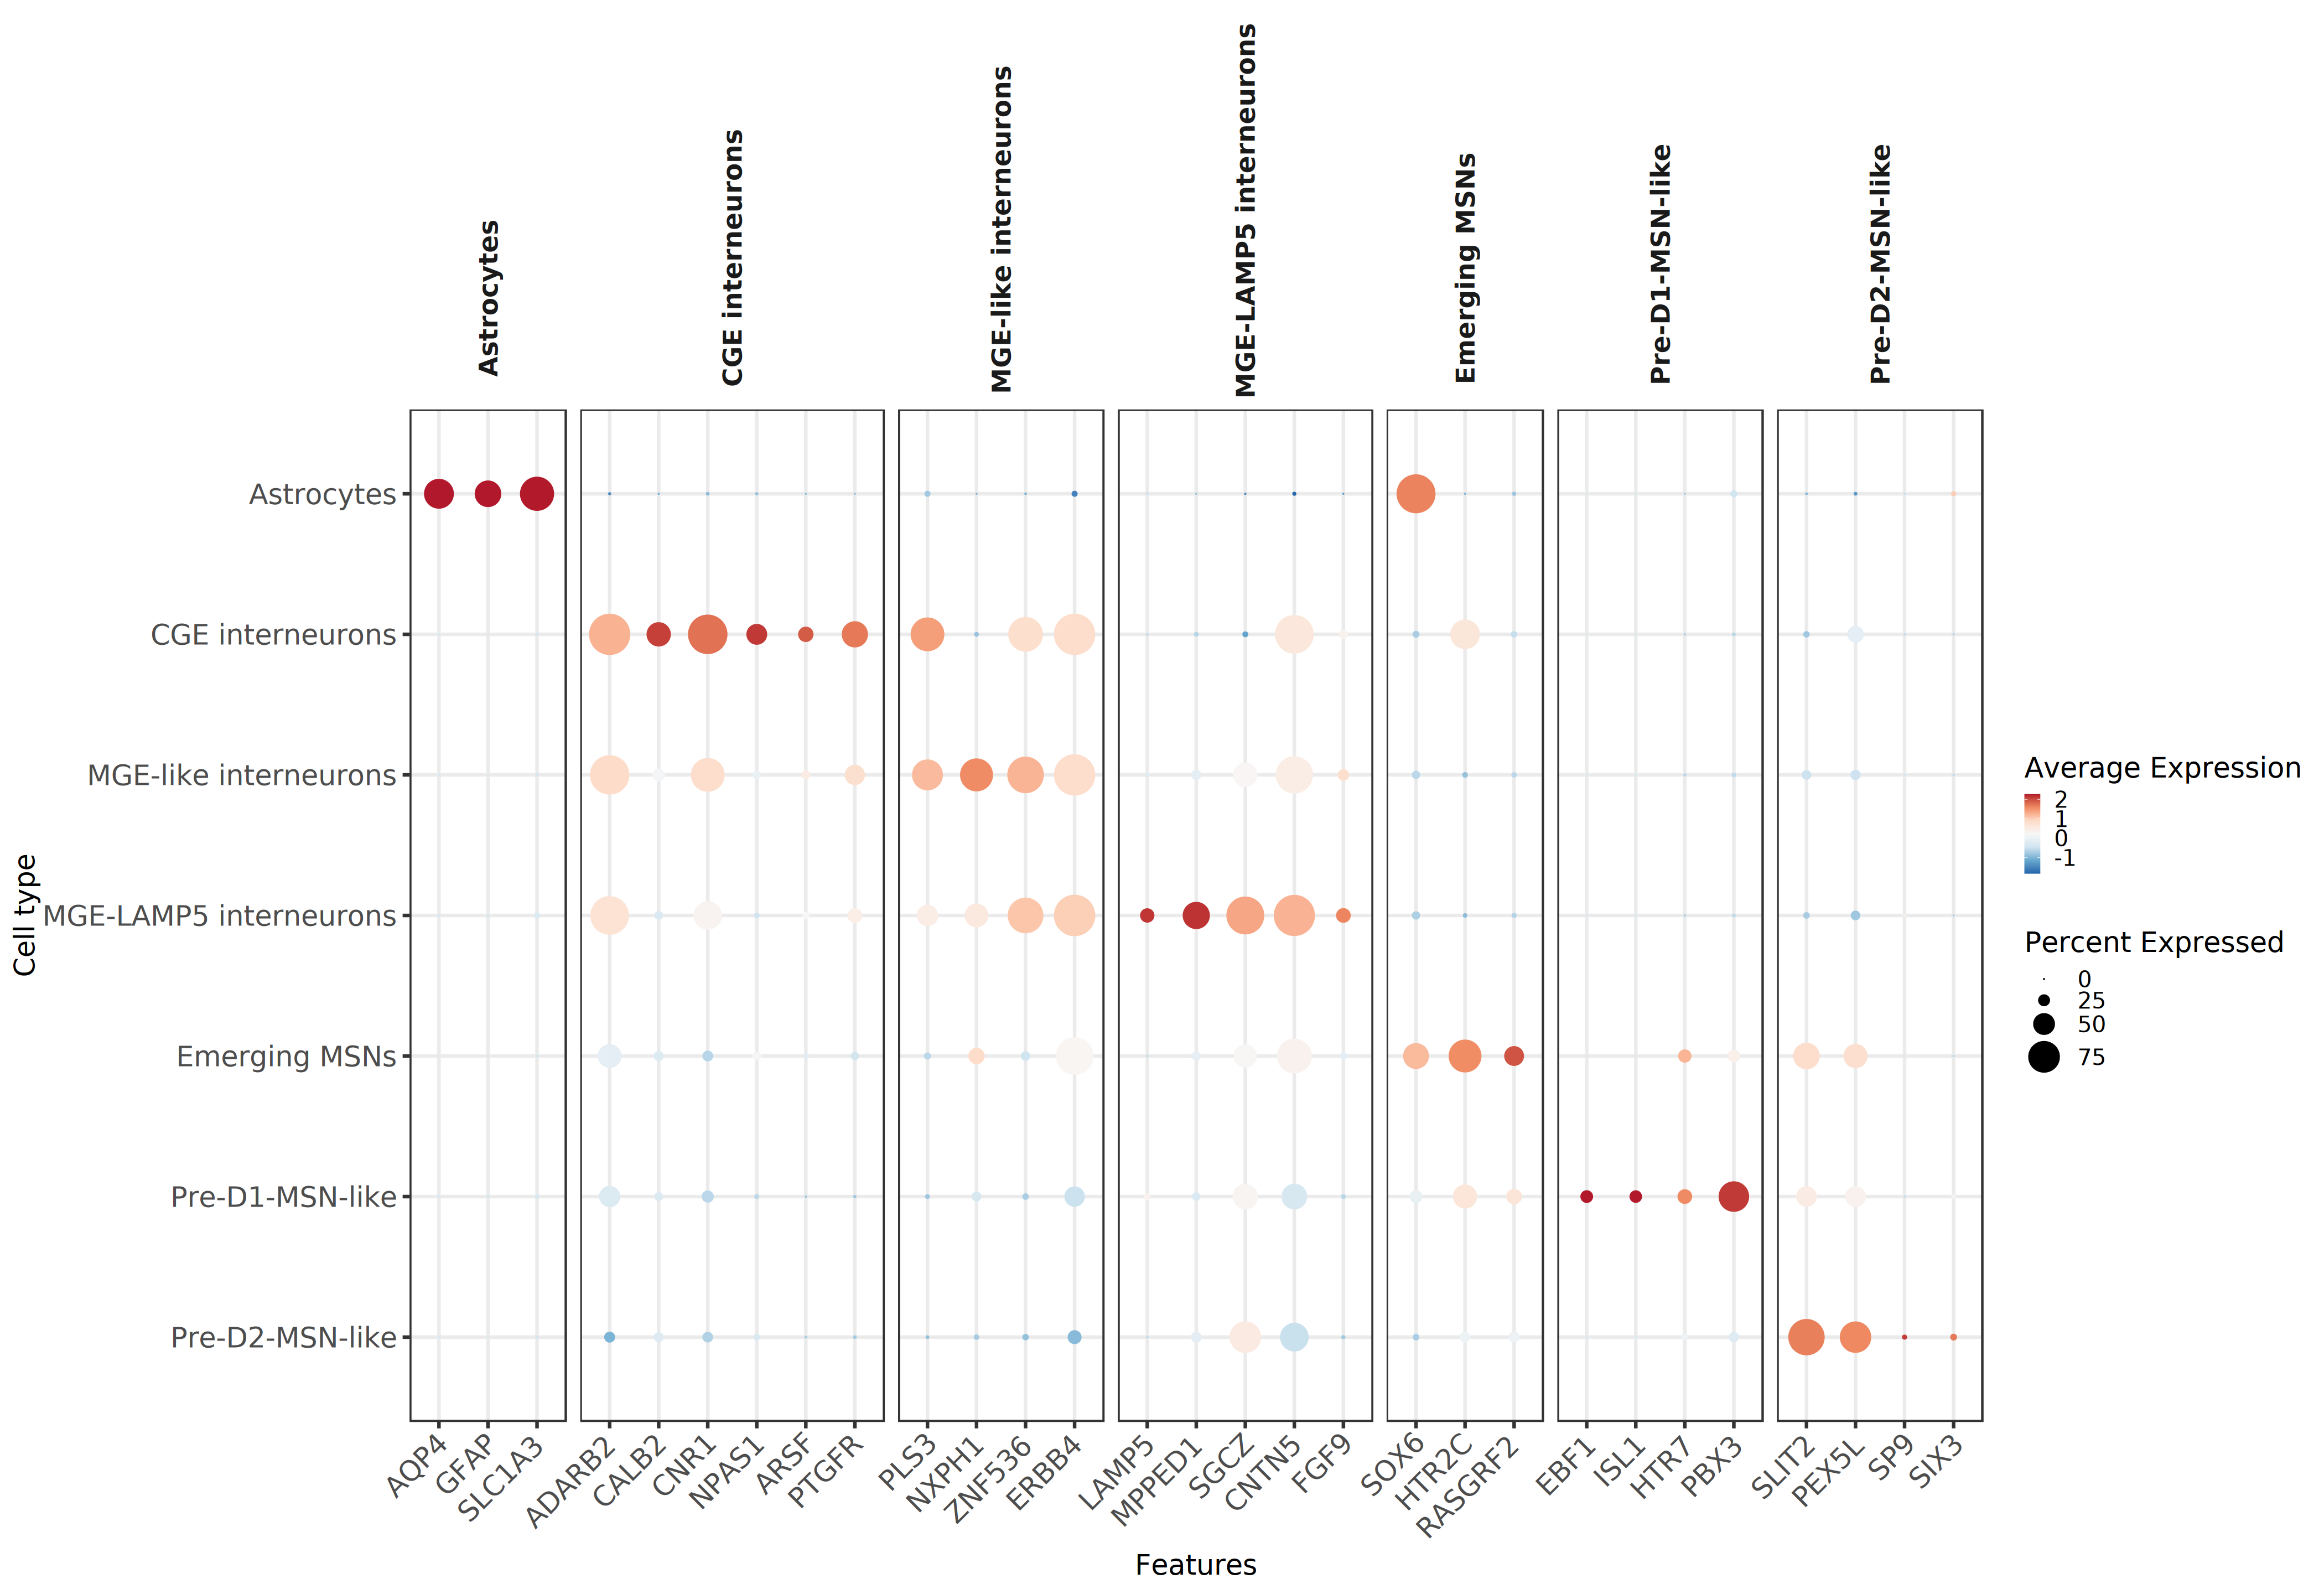

In [186]:
options(repr.plot.width=35, repr.plot.height=24)   

markers_plot <- DotPlot(object = grafts_conf_batch, features = marker_genes, group.by = "annotation_markers2", dot.scale = 17) 
  
markers_plot + theme_bw(base_size = 30) +
    scale_color_distiller(palette= "RdBu", n = 2, direction = -1) +  
    theme(axis.text.x = element_text(size = 30, angle = 45, hjust = 1.1, vjust = 1.1),
          axis.text.y = element_text(size = 30),
          strip.text.x = element_text(face = 'bold', size = 28, angle = 90, hjust = 0.1, vjust = 0.5),
          strip.background = element_blank()) + 
    labs(y= "Cell type") +
    scale_y_discrete(limits = rev(c("Astrocytes", "CGE interneurons","MGE-like interneurons", "MGE-LAMP5 interneurons",
                     "Emerging MSNs", "Pre-D1-MSN-like", "Pre-D2-MSN-like"))) +
    scale_x_discrete(labels = function(x) ensembl_to_symbol[x])                 

## Cell proportions

In [ ]:
cell_num_tot <- as.data.frame(table(grafts_conf_batch$samples))
colnames(cell_num_tot) <- c('sample_name', 'n')

sample_proportions <- data.frame()
cell_proportion_grafts <- data.frame()

for (cell_type in unique(grafts_conf_batch$annotation_unified)){

    cell_subset <- subset(grafts_conf_batch , subset = annotation_unified == cell_type)
    
    if (nrow(cell_subset) == 0) {   
        next
    }

        for (sample in unique(cell_subset$samples)){
            cell_subset2 <- cell_subset@meta.data[which(cell_subset@meta.data$samples == sample),]

            cell_tot_subset_grafts <- subset(cell_num_tot, subset = sample_name == sample)


            cell_num <-  as.data.frame(table(cell_subset2$samples))  
            colnames(cell_num) <- c('sample_name', 'n')
            cell_num$annotation <- cell_type
            cell_num$tot_cells <- cell_tot_subset_grafts$n
            cell_num$ratio <- (cell_num$n / cell_num$tot_cells) * 100
            
        sample_proportions <- rbind(sample_proportions, cell_num)
    
        }
    
            sample_proportions$weight_mean <- sum(sample_proportions[sample_proportions$annotation == cell_type, "ratio"] * 
                                          sample_proportions[sample_proportions$annotation == cell_type, "tot_cells"]) / 
                                          sum(sample_proportions[sample_proportions$annotation == cell_type, "tot_cells"])
            sample_proportions$error <- sd(sample_proportions[sample_proportions$annotation == cell_type, "ratio"])
    
            rat_average <- data.frame('Average', '-', cell_type, '-', sample_proportions$weight_mean, sample_proportions$weight_mean, '-')
            colnames(rat_average) <- colnames(sample_proportions)

    
            cell_proportion_grafts <- rbind(cell_proportion_grafts, sample_proportions, rat_average[1,])
            
            sample_proportions <- data.frame()

    print(cell_proportion_grafts)
}

In [ ]:
cell_proportion_grafts$graft <- sub(".*_(R[0-9]+_trp[0-9_]+)(?:_S[0-9]+)?$", "\\1", cell_proportion_grafts$sample_name)
cell_proportion_grafts$rat <- ifelse(cell_proportion_grafts$sample_name == 'Average', 'Average',
                                    ifelse(cell_proportion_grafts$graft == 'R10_trp1', 'Rat 1', 
                                    ifelse(cell_proportion_grafts$graft == 'R12_trp2_3', 'Rat 2',
                                    ifelse(cell_proportion_grafts$graft == 'R2_trp3_4', 'Rat 3', 'Rat 4'))))

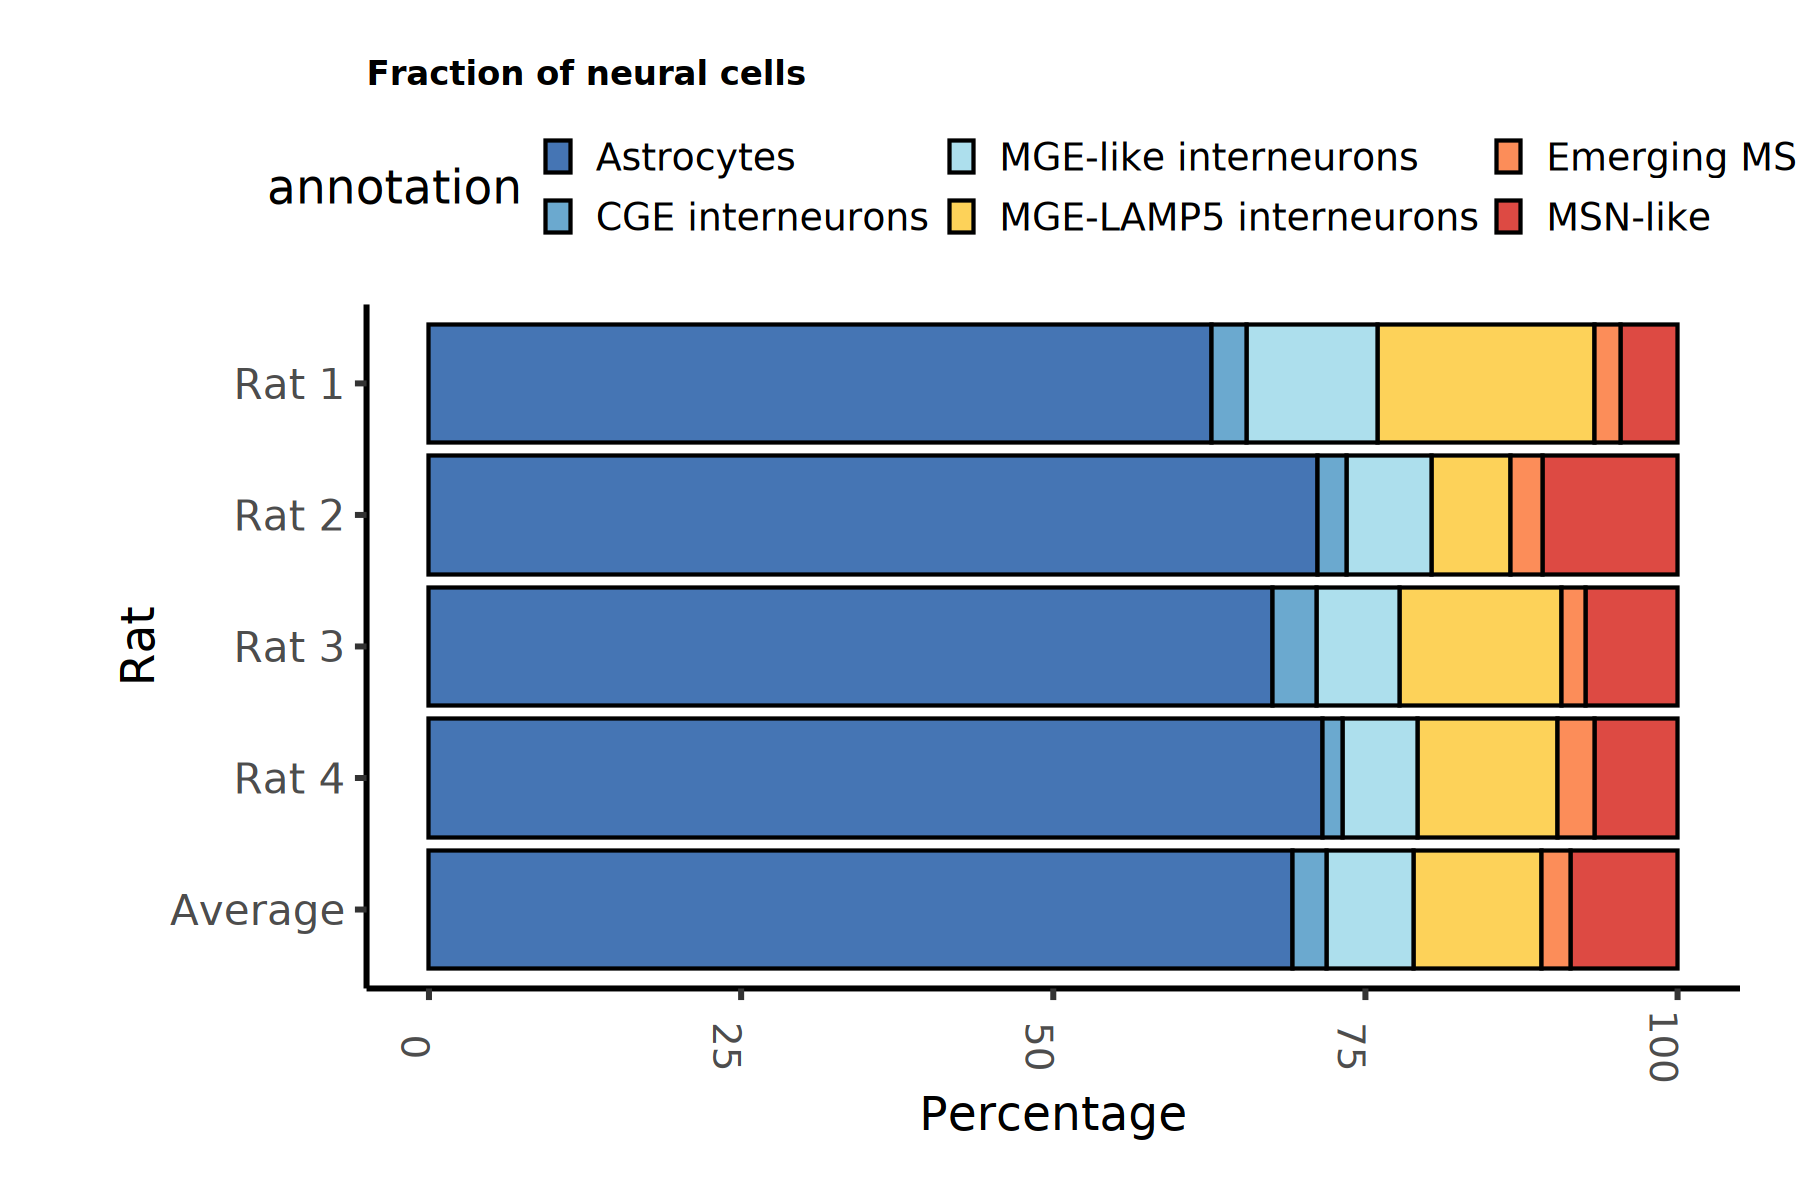

In [334]:
options(repr.plot.width=15, repr.plot.height=10)   

cell_type_order <- c('Astrocytes', 'CGE interneurons', 'MGE-like interneurons', 'MGE-LAMP5 interneurons', 'Emerging MSNs', 'MSN-like')
rat_order <- c('Rat 1', 'Rat 2', 'Rat 3', 'Rat 4', 'Average')
cell_proportion_grafts$rat <- factor(cell_proportion_grafts$rat, levels = rat_order)

cell_proportion_grafts$annotation <- factor(cell_proportion_grafts$annotation, levels = cell_type_order)
cell_proportion_grafts$graft <- as.character(cell_proportion_grafts$graft)

colors = c('#4575B4', '#6BA9CF', '#ADDFED', '#FDD259', '#FC8D59', '#DD4A43', 'orange2')

ggplot(cell_proportion_grafts, aes(x = ratio, y = rat, fill = annotation)) +  
    geom_bar(stat = 'identity', color = 'black', position = position_stack(reverse = TRUE), width = 0.9, linewidth = 0.9) +
    scale_fill_manual(values = colors) +
    theme_classic(base_size = 28) + 
    theme(plot.margin = unit(c(0.5, 0.5, 0.5, 1), "inches"),
          axis.text.x = element_text(size = 23, angle = 270),
          axis.text.y = element_text(size = 25),
          plot.title = element_text(face = "bold", size = 20),
          legend.position = "top") +
    labs(title = "Fraction of neural cells", x = "Percentage", y = "Rat") + 
    scale_y_discrete(limits = rev(rat_order)) 

## Neural subset

In [ ]:
grafts_noAstro <- subset(grafts_conf_batch, subset = annotation_markers2 != 'Astrocytes')

In [ ]:
grafts_noAstro$annotation_markers2 <- grafts_noAstro$annotation_markers
grafts_noAstro$annotation_markers2 <- ifelse(grafts_noAstro$SCT_snn_res.0.65 == 12 & grafts_noAstro$annotation_markers == 'MSN-like', 'Pre-D2-MSN-like',
                                                ifelse(grafts_noAstro$SCT_snn_res.0.65 != 12 & grafts_noAstro$annotation_markers == 'MSN-like', 'Pre-D1-MSN-like',
                                                       grafts_noAstro$annotation_markers2))

## Normalization & UMAP

In [ ]:
grafts_noAstro <- SCTransform(grafts_noAstro, vst.flavor = "v2", variable.features.n = 3000, ncells = 5000, verbose = FALSE)

In [ ]:
#Cell cylce scoring
human_sub_genes <- readRDS('/GTF_HumanGenes_IDandName_subsetted.rds')

human_s.genes <- subset(human_sub_genes, subset = name %in% cc.genes$s.genes)
s.genes <- human_s.genes$gene_id
human_g2m.genes <- subset(human_sub_genes, subset = name %in% cc.genes$g2m.genes)
g2m.genes <- human_g2m.genes$gene_id
grafts_noAstro <- CellCycleScoring(grafts_noAstro, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
grafts_noAstro$CC.Difference <- grafts_noAstro$S.Score - grafts_noAstro$G2M.Score

In [ ]:
grafts_noAstro <- RunPCA(grafts_noAstro, features = VariableFeatures(object = grafts_noAstro), npcs = 50, reduction.name = "pca")
ElbowPlot(grafts_noAstro, reduction = "pca", ndims = 50)

num_dims <- 50
grafts_noAstro <- RunUMAP(grafts_noAstro, dims = 1:num_dims, reduction = "pca", reduction.name = "umap", reduction.key = "umap", verbose = FALSE)

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)   
num_dims <- 50

#Clustering loop
grafts_noAstro <- FindNeighbors(grafts_noAstro, reduction = "pca", dims = 1:num_dims)
for (res_val in seq(0.05, 0.85, 0.2)) {
    grafts_noAstro <- FindClusters(grafts_noAstro, resolution = res_val, method = 4)
    grafts_noAstro <- RunUMAP(grafts_noAstro, dims = 1:num_dims, reduction = "pca", reduction.name = "umap")
}

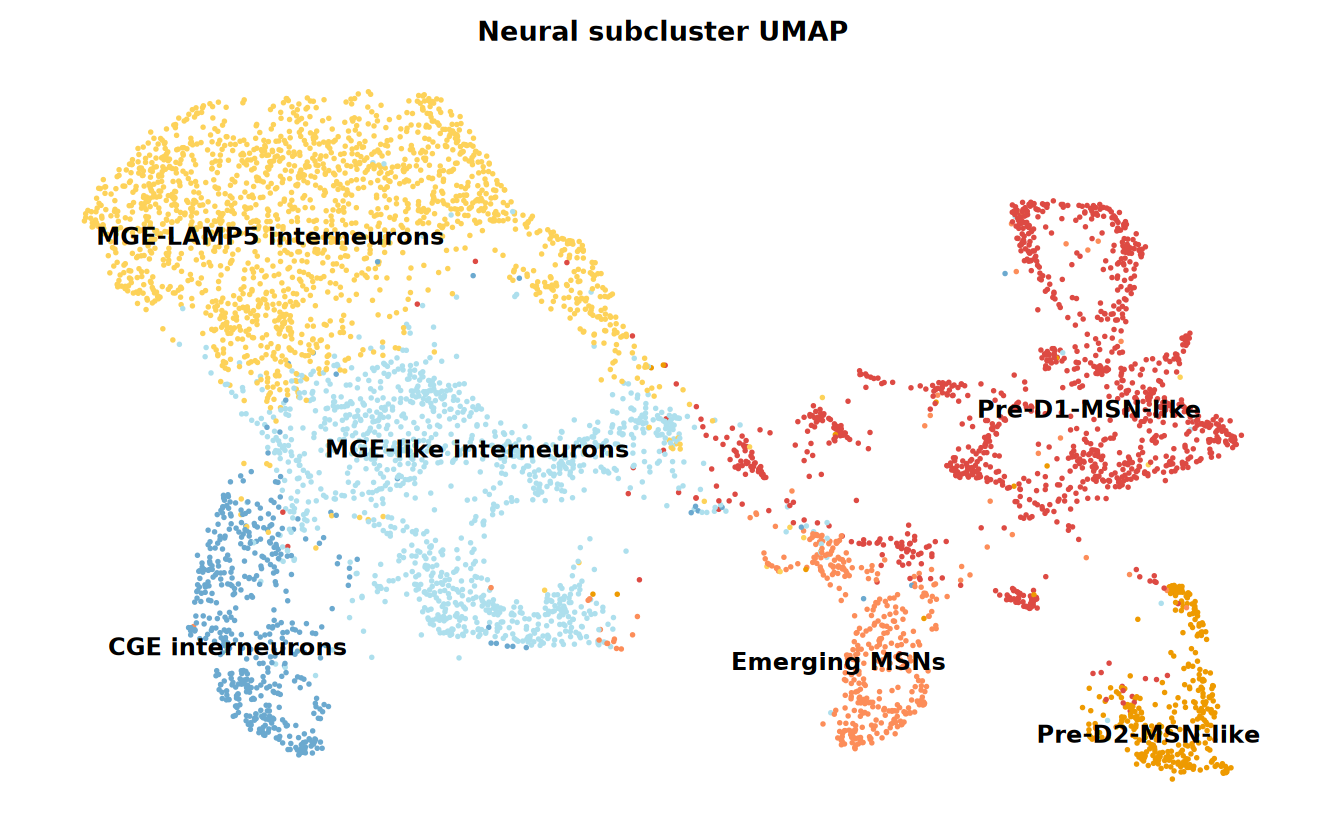

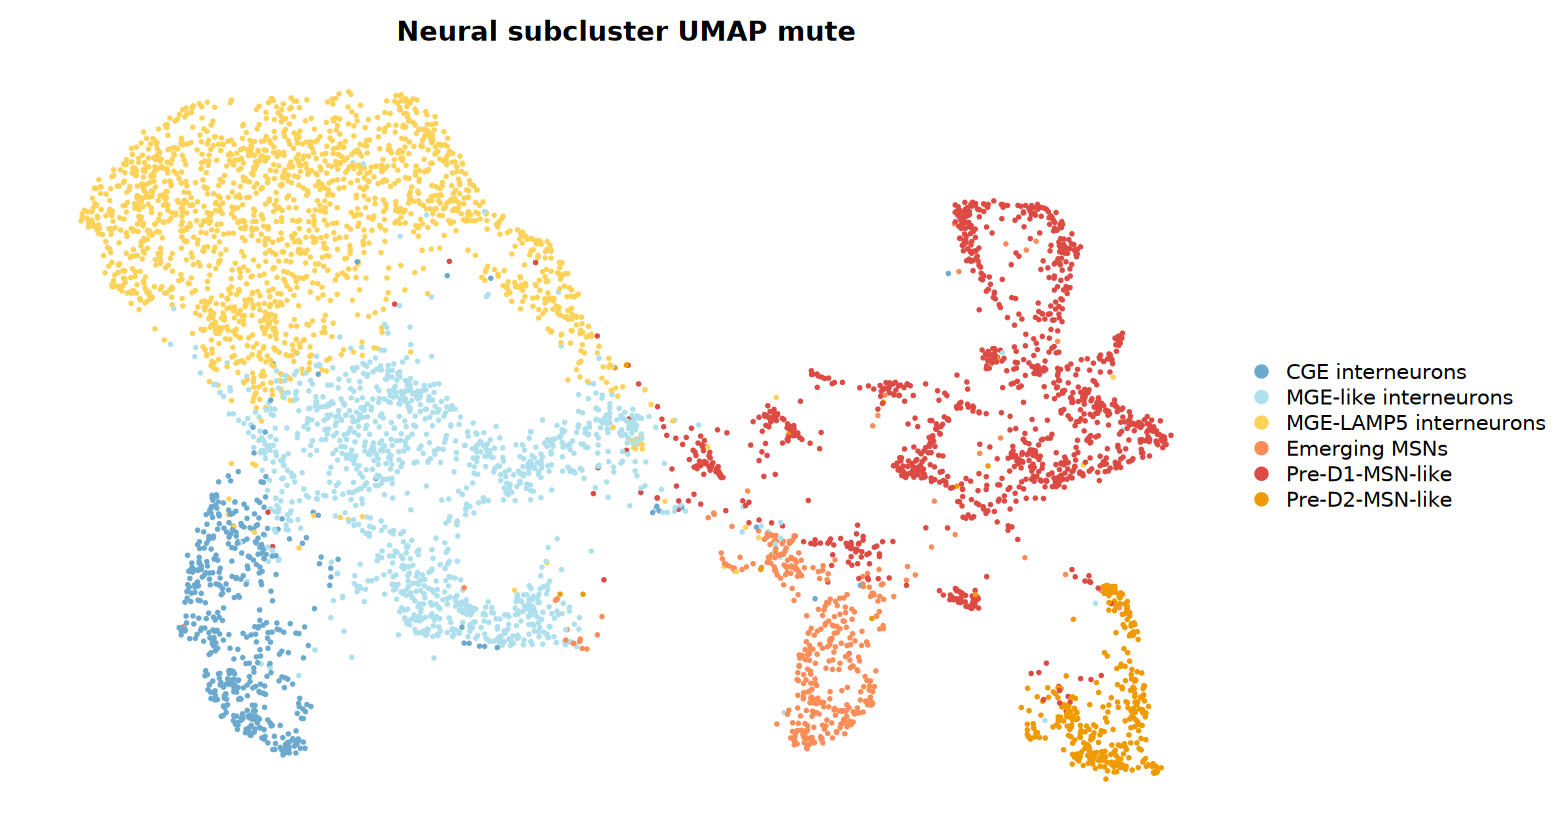

In [39]:
options(repr.plot.width=11, repr.plot.height=7)   
labels_order <- c('CGE interneurons', 'MGE-like interneurons', 'MGE-LAMP5 interneurons', 'Emerging MSNs', "Pre-D1-MSN-like", "Pre-D2-MSN-like")
grafts_noAstro$annotation_markers2 <- factor(grafts_noAstro$annotation_markers2, levels = labels_order)

Idents(grafts_noAstro) <- 'annotation_markers2'
p <- DimPlot(grafts_noAstro, reduction = "umap", group.by = "annotation_markers2", pt.size = 0.5,
        cols = c('#6BA9CF', '#ADDFED', '#FDD259', '#FC8D59', '#DD4A43', 'orange2')) + NoLegend() + NoAxes() +
    ggtitle('Neural subcluster UMAP') 
LabelClusters(p, id = "annotation_markers2",  fontface = "bold", size = 5)

options(repr.plot.width=13, repr.plot.height=7)   
DimPlot(grafts_noAstro, reduction = "umap", group.by = "annotation_markers2", pt.size = 0.5, cols = c('#6BA9CF', '#ADDFED', '#FDD259', '#FC8D59', '#DD4A43', 'orange2')) +
    NoAxes() + ggtitle('Neural subcluster UMAP mute')

# Heatmap by annotation

### DEA per cell type
Without astrocytes

In [ ]:
Idents(grafts_noAstro) <- grafts_noAstro$annotation_markers2
dea_grafts_ann_divided <- FindAllMarkers(grafts_noAstro, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, assay = "SCT")

In [ ]:
dea_grafts_ann_divided <- dea_grafts_ann_divided[order(dea_grafts_ann_divided$avg_log2FC, decreasing = TRUE),]
top_marker_grafts_ann_div <- dea_grafts_ann_divided[dea_grafts_ann_divided$p_val_adj < 0.05,]

top_marker_grafts_ann_div <- top_marker_grafts_ann_div %>%
  group_by(cluster) %>%
  slice_max(n = 30, order_by = avg_log2FC) 

In [ ]:
top_marker_grafts_ann_div$cluster <- factor(top_marker_grafts_ann_div$cluster, levels = c("CGE interneurons", "MGE-LAMP5 interneurons", "MGE-like interneurons",
                      "Emerging MSNs", "Pre-D1-MSN-like", "Pre-D2-MSN-like"))
mart <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")
complete_degs_grafts_div <- data.frame()

for (clust in levels(top_marker_grafts_ann_div$cluster)) { 
    
    c_tf <- top_marker_grafts_ann_div[top_marker_grafts_ann_div$cluster == clust & top_marker_grafts_ann_div$p_val_adj < 0.05, ]
    ensembl_ids <- c_tf$gene
    
    gene_symbols <- tryCatch({
        getBM(attributes = c("ensembl_gene_id", "hgnc_symbol"),
              filters = "ensembl_gene_id",
              values = ensembl_ids,
              mart = mart)
    }, error = function(e) {
        return(data.frame(ensembl_gene_id = character(0), hgnc_symbol = character(0)))
    })
    
    c_tf <- merge(c_tf, gene_symbols, by.x = "gene", by.y = "ensembl_gene_id", all.x = TRUE, sort = FALSE)
    complete_degs_grafts_div <- rbind(complete_degs_grafts_div, c_tf)
}

In [ ]:
degs_heatmap_div <- complete_degs_grafts_div$gene

### Heatmap 
30 top  degs of each cell type

Warning message in DoHeatmap(grafts_noAstro, features = degs_heatmap_div, size = 5, :
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: ENSG00000154146, ENSG00000182568”


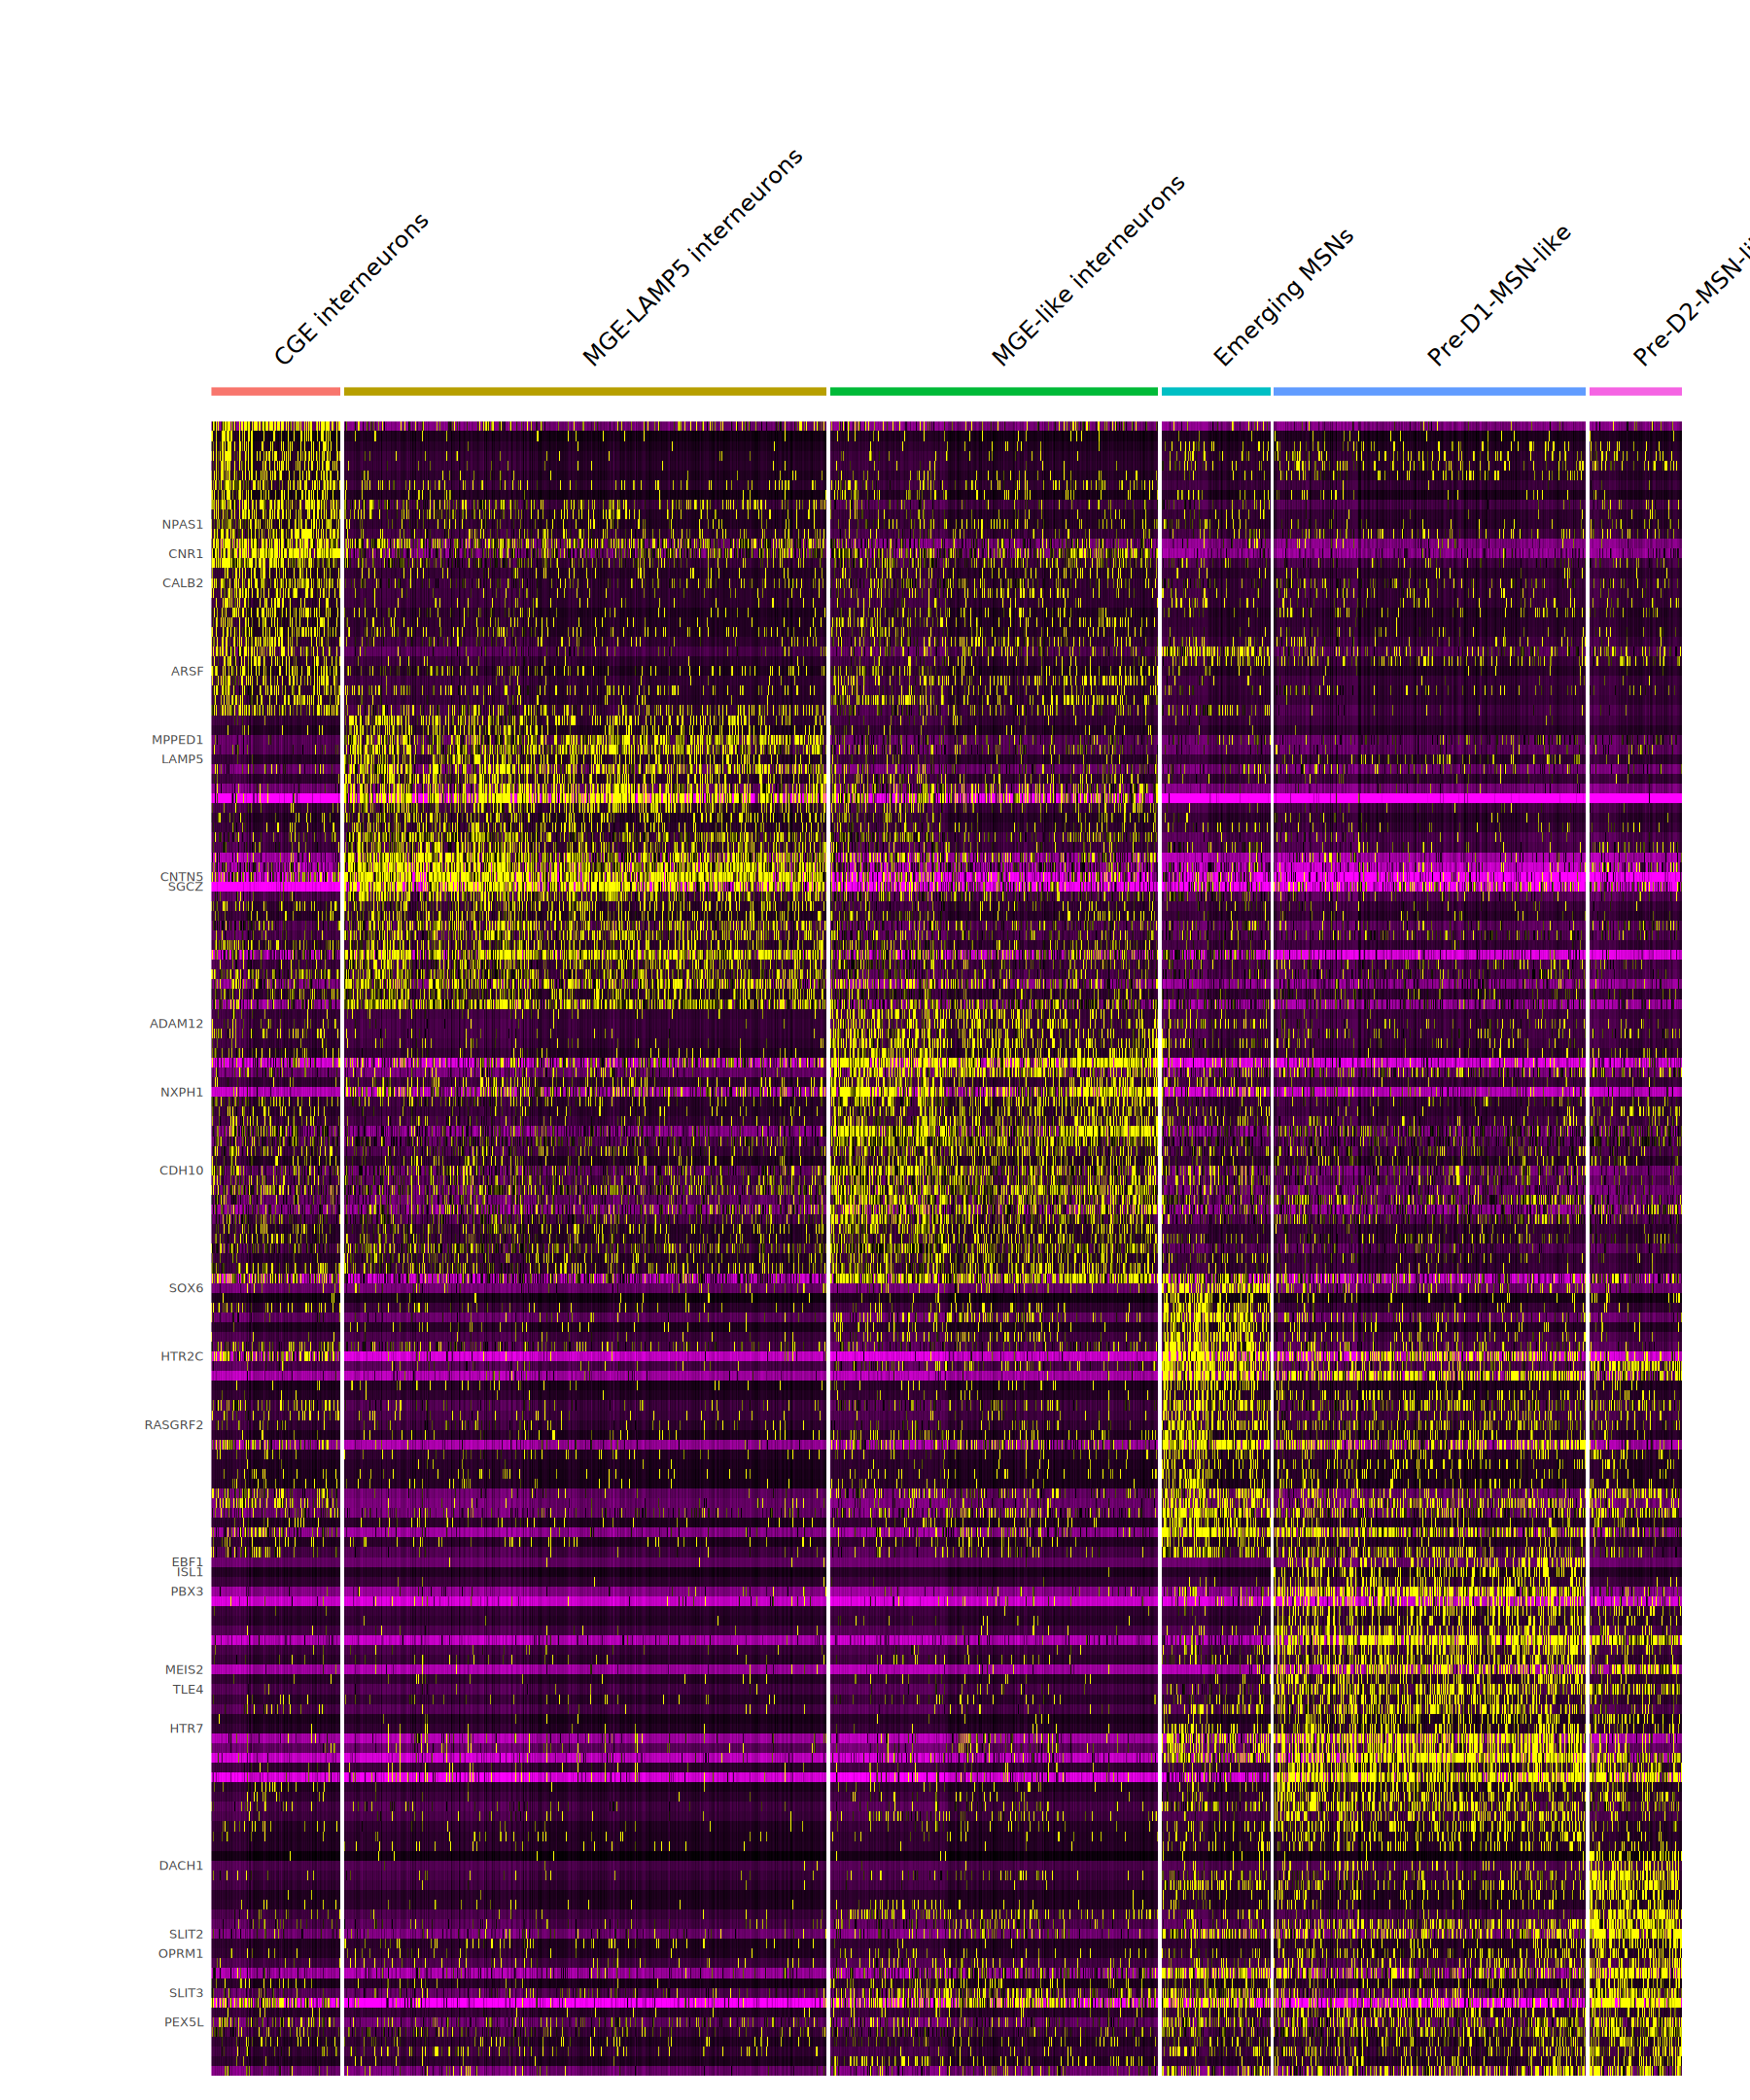

In [91]:
options(repr.plot.width=15, repr.plot.height=18) 

grafts_noAstro@meta.data$annotation_markers2 <- factor(grafts_noAstro@meta.data$annotation_markers2, levels = c("CGE interneurons", "MGE-LAMP5 interneurons", "MGE-like interneurons",
                      "Emerging MSNs", "Pre-D1-MSN-like", "Pre-D2-MSN-like"))

genes_to_label <- c('ENSG00000172137' = 'CALB2', #CGE
                    'ENSG00000118432' = 'CNR1',
                    'ENSG00000130751' = 'NPAS1',
                    'ENSG00000062096' = 'ARSF',
                    
                    'ENSG00000125869' = 'LAMP5', #MGE-LAMP5 int.
                    'ENSG00000186732' = 'MPPED1',
                    'ENSG00000185053' = 'SGCZ',
                    'ENSG00000149972' = 'CNTN5',
                    
                    'ENSG00000122584' = 'NXPH1', #MGE-like
                    'ENSG00000148848' = 'ADAM12',
                    'ENSG00000040731' = 'CDH10',
                    
                    'ENSG00000110693' = 'SOX6', #Emerging
                    'ENSG00000147246' = 'HTR2C',
                    'ENSG00000113319' =  'RASGRF2',
                    'ENSG00000114757' = 'PEX5L',
                    
                    'ENSG00000148680' = 'HTR7', #Pre-D1
                    'ENSG00000164330' = 'EBF1',
                    'ENSG00000016082' = 'ISL1',
                    'ENSG00000167081' = 'PBX3',
                    'ENSG00000134138' = 'MEIS2', #from dea
                    
                    'ENSG00000276644' = 'DACH1', #Pre-D2 
                    'ENSG00000145147' = 'SLIT2',
                    'ENSG00000112038' = 'OPRM1',
                    'ENSG00000184347' = 'SLIT3', 
                    'ENSG00000106829' = 'TLE4'
)
    
gene_order <- levels(heat$data$Feature)

y_labels <- sapply(gene_order, function(gene) {
    ifelse(gene %in% names(genes_to_label), genes_to_label[gene], "")
})


heat <- DoHeatmap(grafts_noAstro, features = degs_heatmap_div, size = 5, group.bar.height = 0.005, group.by = 'annotation_markers2')

heat +
    scale_y_discrete(labels = y_labels) +
    theme(plot.margin = unit(c(0,1.2,0,3), "cm"), axis.text.y = element_text(size = 7.5)) +
NoLegend()

## Neural cell proportions

In [ ]:
cell_num_tot <- as.data.frame(table(grafts_noAstro$samples))
colnames(cell_num_tot) <- c('sample_name', 'n')

sample_proportions <- data.frame()
cell_proportion_grafts <- data.frame()

for (cell_type in unique(grafts_noAstro$annotation_markers2)){

    cell_subset <- subset(grafts_noAstro , subset = annotation_markers2 == cell_type)

    if (nrow(cell_subset) == 0) {  
        next
    }

        for (sample in unique(cell_subset$samples)){
            cell_subset2 <- cell_subset@meta.data[which(cell_subset@meta.data$samples == sample),]

            cell_tot_subset_grafts <- subset(cell_num_tot, subset = sample_name == sample)


            cell_num <-  as.data.frame(table(cell_subset2$samples))  
            colnames(cell_num) <- c('sample_name', 'n')
            cell_num$annotation <- cell_type
            cell_num$tot_cells <- cell_tot_subset_grafts$n
            cell_num$ratio <- (cell_num$n / cell_num$tot_cells) * 100

        sample_proportions <- rbind(sample_proportions, cell_num)
    
        }

            sample_proportions$weight_mean <- sum(sample_proportions[sample_proportions$annotation == cell_type, "ratio"] * 
                                          sample_proportions[sample_proportions$annotation == cell_type, "tot_cells"]) / 
                                          sum(sample_proportions[sample_proportions$annotation == cell_type, "tot_cells"])
            sample_proportions$error <- sd(sample_proportions[sample_proportions$annotation == cell_type, "ratio"])
    
            rat_average <- data.frame('Average', '-', cell_type, '-', sample_proportions$weight_mean, sample_proportions$weight_mean, '-')
            colnames(rat_average) <- colnames(sample_proportions)

    
            cell_proportion_grafts <- rbind(cell_proportion_grafts, sample_proportions, rat_average[1,])
            
            sample_proportions <- data.frame()

    print(cell_proportion_grafts)
}

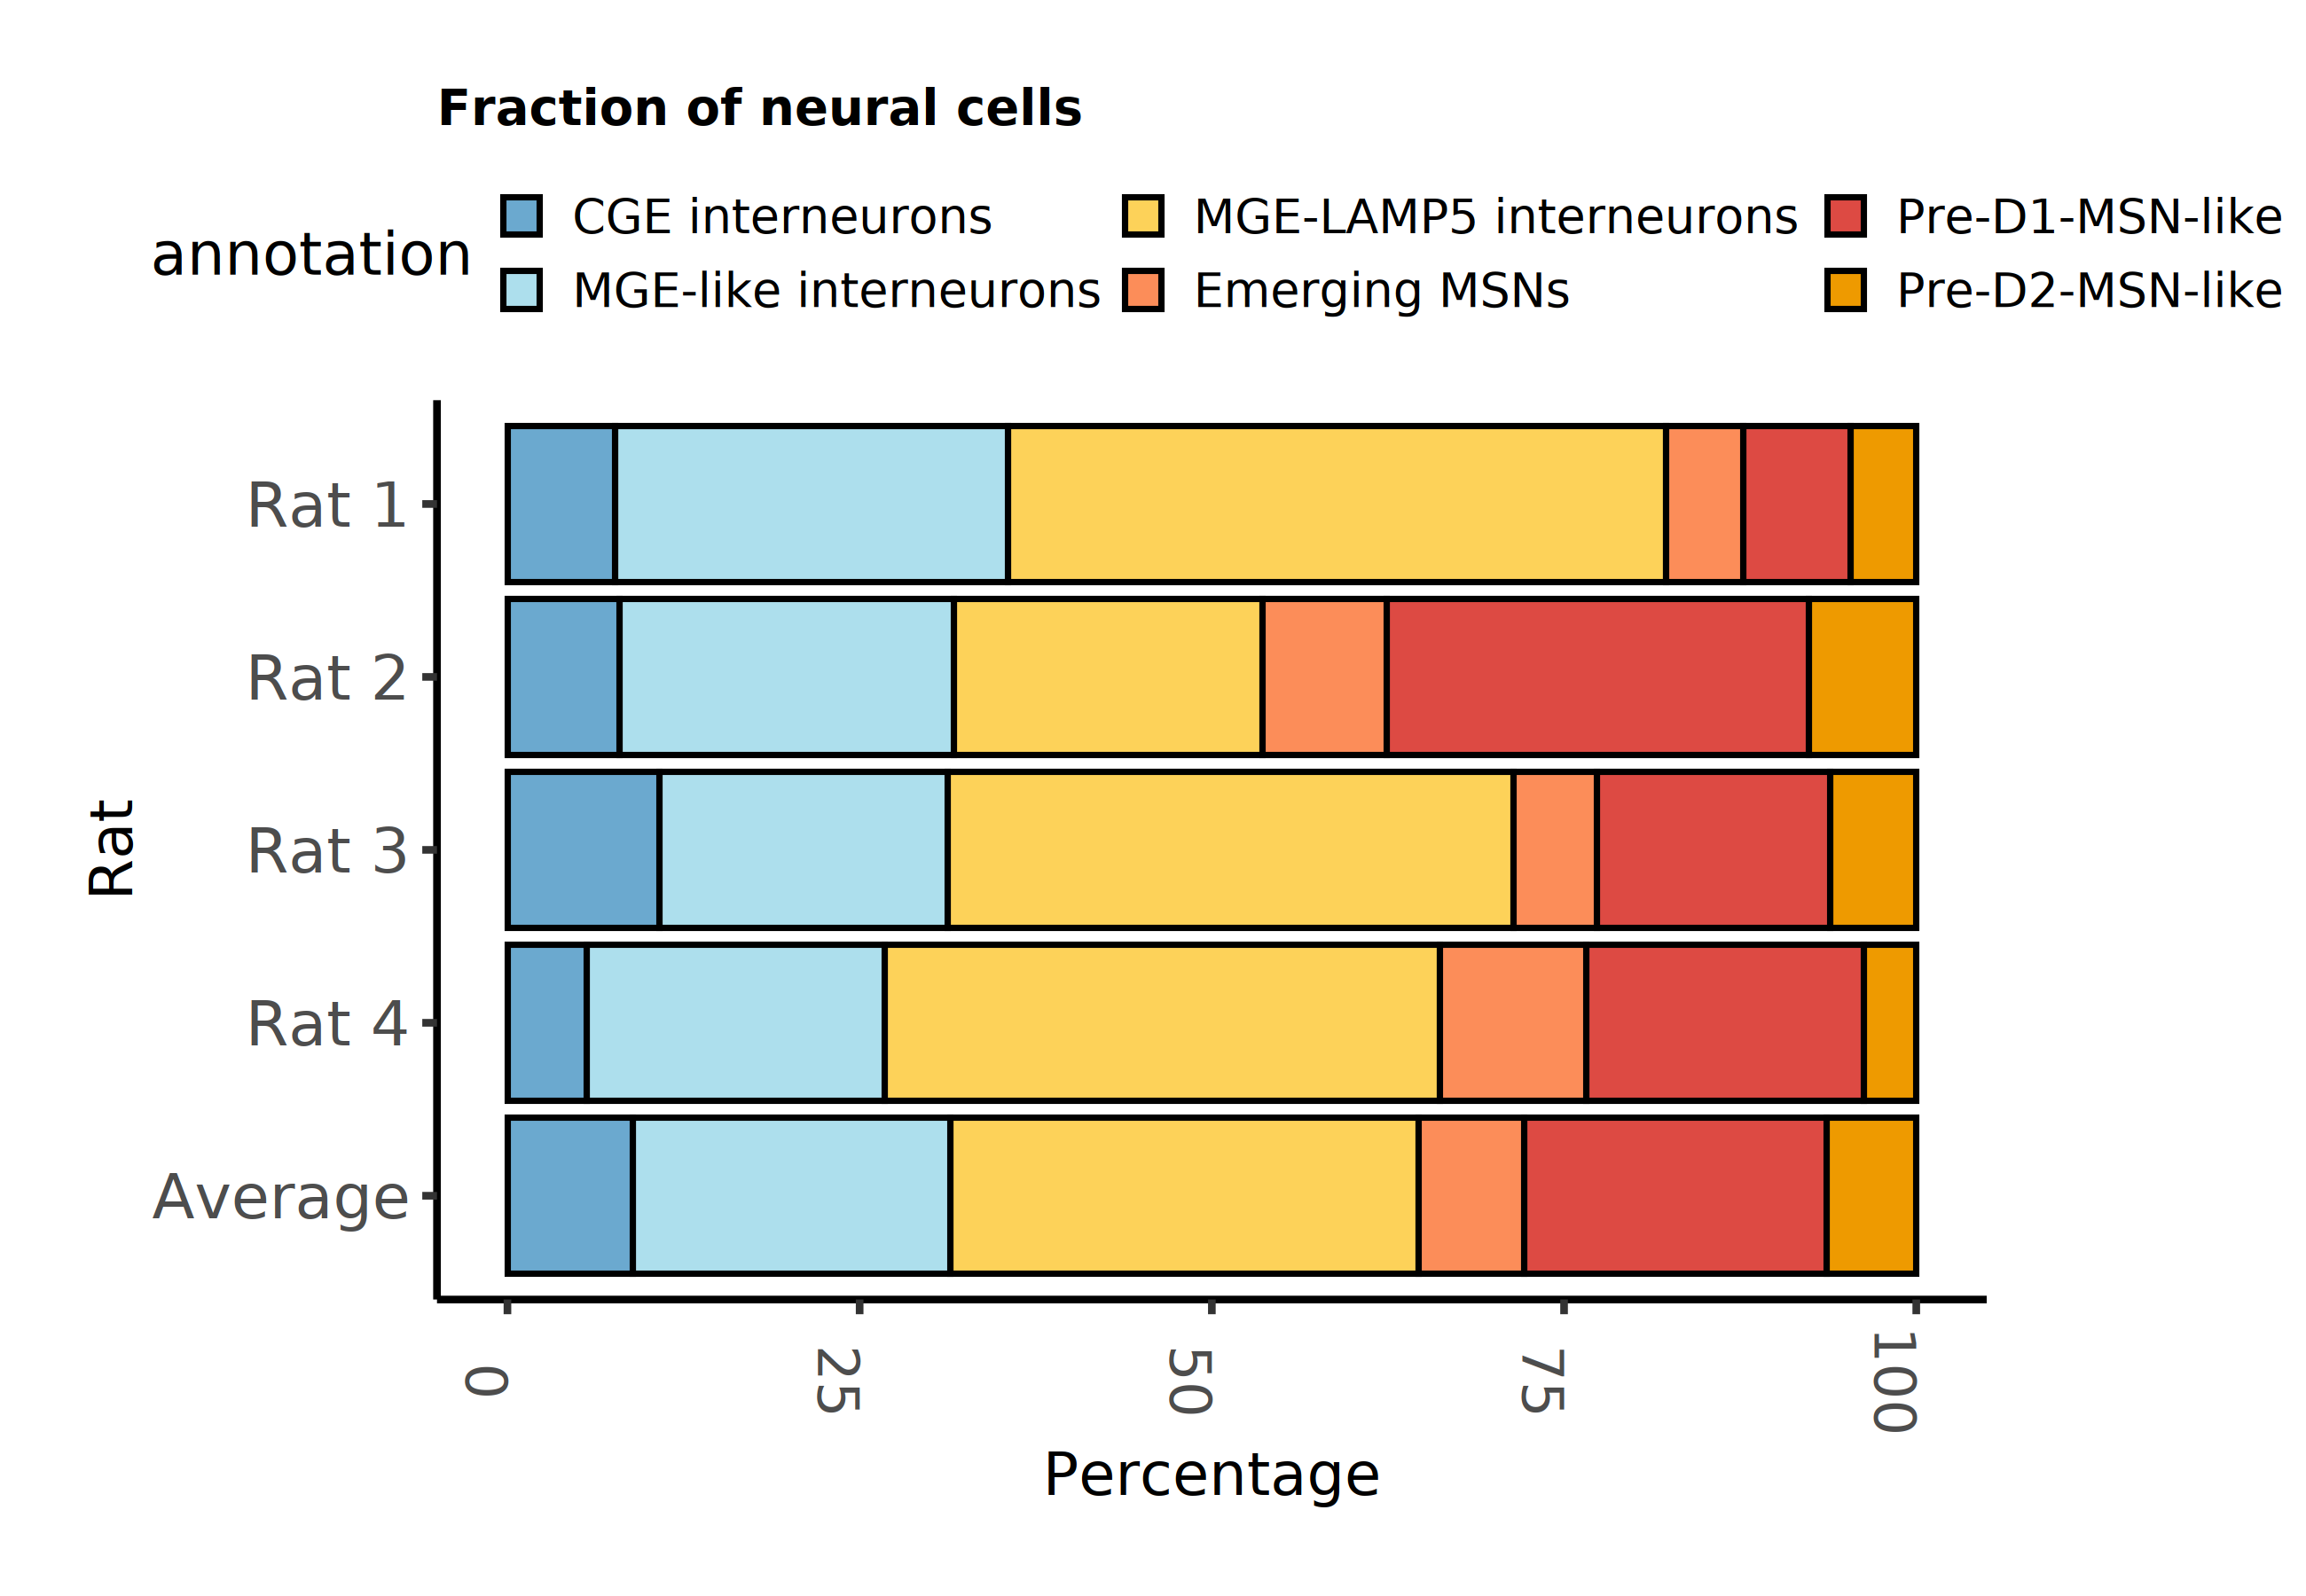

In [293]:
options(repr.plot.width=13, repr.plot.height=9)  

cell_type_order <- c('CGE interneurons', 'MGE-like interneurons', 'MGE-LAMP5 interneurons', 'Emerging MSNs', 'Pre-D1-MSN-like', 'Pre-D2-MSN-like')
rat_order <- c('Rat 1', 'Rat 2', 'Rat 3', 'Rat 4', 'Average')
cell_proportion_grafts$rat <- factor(cell_proportion_grafts$rat, levels = rat_order)

cell_proportion_grafts$annotation <- factor(cell_proportion_grafts$annotation, levels = cell_type_order)
cell_proportion_grafts$graft <- as.character(cell_proportion_grafts$graft)

colors = c('#6BA9CF', '#ADDFED', '#FDD259', '#FC8D59', '#DD4A43', 'orange2')

ggplot(cell_proportion_grafts, aes(x = ratio, y = rat, fill = annotation)) +  
    geom_bar(stat = 'identity', color = 'black', position = position_stack(reverse = TRUE), width = 0.9, linewidth = 0.9) +
    scale_fill_manual(values = colors) +
    theme_classic(base_size = 24) + 
    theme(plot.margin = unit(c(0.5, 1.8, 0.5, 0.5), "inches"),
          axis.text.x = element_text(size = 23, angle = 270),
          axis.text.y = element_text(size = 25),
          plot.title = element_text(face = "bold", size = 20),
          legend.position = "top") +
    labs(title = "Fraction of neural cells", x = "Percentage", y = "Rat") + 
    scale_y_discrete(limits = rev(rat_order)) 